In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

AttributeError: 'TypeMap' object has no attribute 'get_dt_container_cls'

In [4]:
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

### load experiments_table from cache

In [5]:
cache_dir = loading.get_platform_analysis_cache_dir()
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
# print(cache_dir)

In [6]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


### load cells table

In [7]:
cells_table = loading.get_cell_table()
print(len(cells_table.ophys_experiment_id.unique()))

1249


### get number of experiments, mice & cells per experience level & cell type 

In [8]:
def value_counts(df, conditions=['cell_type', 'experience_level', 'mouse_id']):
    """
    group by the first conditions and count the last one
    """
    counts = df.groupby(conditions).count().reset_index().groupby(conditions[:-1]).count()
    counts = counts[[conditions[-1]]].rename(columns={conditions[-1]:'n_'+conditions[-1]})
    return counts

### full experiment table

In [9]:
mice = value_counts(experiments_table, conditions=['cell_type', 'experience_level', 'mouse_id'])
experiments = value_counts(experiments_table, conditions=['cell_type', 'experience_level', 'ophys_experiment_id'])
containers = value_counts(experiments_table, conditions=['cell_type', 'experience_level', 'ophys_container_id'])

counts = mice.merge(experiments, on=['cell_type', 'experience_level'])
counts = counts.merge(containers,  on=['cell_type', 'experience_level'])
counts

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  41                    280   
               Novel 1                   36                     71   
               Novel >1                  41                    196   
Sst Inhibitory Familiar                  19                    144   
               Novel 1                   15                     37   
               Novel >1                  19                    107   
Vip Inhibitory Familiar                  22                    217   
               Novel 1                   17                     47   
               Novel >1                  22                    150   

                                 n_ophys_container_id  
cell_type      experience_level                        
Excitatory     Familiar                            88  
               Novel 1                             71  
               Novel >1                            88  
Sst Inhibitory Familiar                            46  
               Novel 1                             37  
               Novel >1                            45  
Vip Inhibitory Familiar                            69  
               Novel 1                             47  
               Novel >1                            66

### full cells table

In [26]:
def count_mice_expts_containers_cells(df):
    mice = value_counts(df, conditions=['cell_type', 'experience_level', 'mouse_id'])
    experiments = value_counts(df, conditions=['cell_type', 'experience_level', 'ophys_experiment_id'])
    containers = value_counts(df, conditions=['cell_type', 'experience_level', 'ophys_container_id'])
    cells = value_counts(df, conditions=['cell_type', 'experience_level', 'cell_specimen_id'])

    counts = mice.merge(experiments, on=['cell_type', 'experience_level'])
    counts = counts.merge(containers,  on=['cell_type', 'experience_level'])
    counts = counts.merge(cells,  on=['cell_type', 'experience_level'])
    return counts

In [11]:
count_mice_expts_containers_cells(cells_table)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  41                    280   
               Novel 1                   36                     71   
               Novel >1                  41                    196   
Sst Inhibitory Familiar                  19                    144   
               Novel 1                   15                     37   
               Novel >1                  19                    107   
Vip Inhibitory Familiar                  22                    217   
               Novel 1                   17                     47   
               Novel >1                  22                    150   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            88               18782  
               Novel 1                             71                9225  
               Novel >1                            88               15705  
Sst Inhibitory Familiar                            46                 738  
               Novel 1                             37                 414  
               Novel >1                            45                 678  
Vip Inhibitory Familiar                            69                1852  
               Novel 1                             47                 792  
               Novel >1                            66                1547

### limit to last familiar active and second novel active

In [12]:
def limit_to_last_familiar_second_novel_active(df):
    """
    Drops rows that are not the last familiar active session or the second novel active session
    """
    # drop novel sessions that arent the second active one
    indices = df[(df.experience_level=='Novel >1')&(df.second_novel_active==False)].index.values
    df = df.drop(labels=indices, axis=0)
    
    # drop Familiar sessions that arent the last active one
    indices = df[(df.experience_level=='Familiar')&(df.last_familiar_active==False)].index.values
    df = df.drop(labels=indices, axis=0)
    
    return df

In [13]:
cells_table = utilities.limit_to_last_familiar_second_novel_active(cells_table)
len(cells_table)

28582

In [14]:
count_mice_expts_containers_cells(cells_table)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  35                     70   
               Novel 1                   36                     71   
               Novel >1                  35                     63   
Sst Inhibitory Familiar                  15                     37   
               Novel 1                   15                     37   
               Novel >1                  15                     30   
Vip Inhibitory Familiar                  17                     47   
               Novel 1                   17                     47   
               Novel >1                  17                     42   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            70                8147  
               Novel 1                             71                9225  
               Novel >1                            63                7666  
Sst Inhibitory Familiar                            37                 392  
               Novel 1                             37                 414  
               Novel >1                            30                 320  
Vip Inhibitory Familiar                            47                 861  
               Novel 1                             47                 792  
               Novel >1                            42                 765

### limit to containers with all 3 experience levels

In [15]:
def get_containers_with_all_experience_levels(experiments_table):
    """
    identifies containers with all 3 experience levels in ['Familiar', 'Novel 1', 'Novel >1']
    """
    experience_level_counts = experiments_table.groupby(['ophys_container_id', 'experience_level']).count().reset_index().groupby(['ophys_container_id']).count()[['experience_level']]
    containers_with_all_experience_levels = experience_level_counts[experience_level_counts.experience_level==3].index.unique()
    return containers_with_all_experience_levels


def limit_to_containers_with_all_experience_levels(experiments_table):
    """
    returns experiment_table limited to containers with all 3 experience levels in ['Familiar', 'Novel 1', 'Novel >1']
    """
    containers_with_all_experience_levels = get_containers_with_all_experience_levels(experiments_table)
    experiments_table = experiments_table[experiments_table.ophys_container_id.isin(containers_with_all_experience_levels)]
    return experiments_table


In [16]:
cells_table = utilities.limit_to_containers_with_all_experience_levels(cells_table)
print(len(cells_table))

26075


In [17]:
count_mice_expts_containers_cells(cells_table)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  15                     30   
               Novel 1                   15                     30   
               Novel >1                  15                     30   
Vip Inhibitory Familiar                  17                     42   
               Novel 1                   17                     42   
               Novel >1                  17                     42   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                7302  
               Novel 1                             62                7974  
               Novel >1                            62                7544  
Sst Inhibitory Familiar                            30                 321  
               Novel 1                             30                 337  
               Novel >1                            30                 320  
Vip Inhibitory Familiar                            42                 794  
               Novel 1                             42                 718  
               Novel >1                            42                 765

### just for Multiscope

In [18]:
multiscope_cells_table = cells_table[cells_table.project_code=='VisualBehaviorMultiscope'].copy()

count_mice_expts_containers_cells(multiscope_cells_table)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                   8                     36   
               Novel 1                    8                     36   
               Novel >1                   8                     36   
Sst Inhibitory Familiar                   5                     20   
               Novel 1                    5                     20   
               Novel >1                   5                     20   
Vip Inhibitory Familiar                   6                     31   
               Novel 1                    6                     31   
               Novel >1                   6                     31   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            36                3604  
               Novel 1                             36                3996  
               Novel >1                            36                3783  
Sst Inhibitory Familiar                            20                 198  
               Novel 1                             20                 215  
               Novel >1                            20                 194  
Vip Inhibitory Familiar                            31                 548  
               Novel 1                             31                 507  
               Novel >1                            31                 523

### limit to cells matched across experience levels

In [19]:
def get_cell_specimen_ids_with_all_experience_levels(df):
    """
    identifies cell_specimen_ids with all 3 experience levels in ['Familiar', 'Novel 1', 'Novel >1'] in the input dataframe
    input dataframe must have column 'cell_specimen_id', such as in ophys_cells_table
    """
    experience_level_counts = df.groupby(['cell_specimen_id', 'experience_level']).count().reset_index().groupby(['cell_specimen_id']).count()[['experience_level']]
    cell_specimen_ids_with_all_experience_levels = experience_level_counts[experience_level_counts.experience_level==3].index.unique()
    return cell_specimen_ids_with_all_experience_levels


def limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table):
    """
    returns dataframe limited to cell_specimen_ids that are present in all 3 experience levels in ['Familiar', 'Novel 1', 'Novel >1']
    input dataframe is typically ophys_cells_table but can be any df with columns 'cell_specimen_id' and 'experience_level'
    """
    cell_specimen_ids_with_all_experience_levels = get_cell_specimen_ids_with_all_experience_levels(cells_table)
    matched_cells_table = cells_table[cells_table.cell_specimen_id.isin(cell_specimen_ids_with_all_experience_levels)].copy()
    return matched_cells_table

In [20]:
matched_cells_table = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table)
len(matched_cells_table)

11823

In [21]:
count_mice_expts_containers_cells(matched_cells_table)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  14                     28   
               Novel 1                   14                     28   
               Novel >1                  14                     28   
Vip Inhibitory Familiar                  17                     41   
               Novel 1                   17                     41   
               Novel >1                  17                     41   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                3326  
               Novel 1                             62                3326  
               Novel >1                            62                3326  
Sst Inhibitory Familiar                            28                 200  
               Novel 1                             28                 200  
               Novel >1                            28                 200  
Vip Inhibitory Familiar                            41                 415  
               Novel 1                             41                 415  
               Novel >1                            41                 415

## Compare selection criteria

### all cells

In [36]:
# load cells table
cells_table = loading.get_cell_table()
print(len(cells_table))

all_cells = count_mice_expts_containers_cells(cells_table)
all_cells

77922


n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  41                    280   
               Novel 1                   36                     71   
               Novel >1                  41                    196   
Sst Inhibitory Familiar                  19                    144   
               Novel 1                   15                     37   
               Novel >1                  19                    107   
Vip Inhibitory Familiar                  22                    217   
               Novel 1                   17                     47   
               Novel >1                  22                    150   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            88               18782  
               Novel 1                             71                9225  
               Novel >1                            88               15705  
Sst Inhibitory Familiar                            46                 738  
               Novel 1                             37                 414  
               Novel >1                            45                 678  
Vip Inhibitory Familiar                            69                1852  
               Novel 1                             47                 792  
               Novel >1                            66                1547

### allow matches for any familiar and any novel >1

In [37]:
# load cells table
cells_table = loading.get_cell_table()
print(len(cells_table))

# limit to containers with all 3 experience levels
cells_table = utilities.limit_to_containers_with_all_experience_levels(cells_table)
print(len(cells_table))

# limit to cells matched across experience levels
matched_cells_table = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table)
len(matched_cells_table)

any_matches = count_mice_expts_containers_cells(matched_cells_table)
any_matches

77922
62384


n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  36                    226   
               Novel 1                   36                     71   
               Novel >1                  36                    142   
Sst Inhibitory Familiar                  15                    112   
               Novel 1                   15                     36   
               Novel >1                  15                     84   
Vip Inhibitory Familiar                  17                    137   
               Novel 1                   17                     44   
               Novel >1                  17                     96   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            71                5695  
               Novel 1                             71                5695  
               Novel >1                            71                5695  
Sst Inhibitory Familiar                            36                 292  
               Novel 1                             36                 292  
               Novel >1                            36                 292  
Vip Inhibitory Familiar                            44                 540  
               Novel 1                             44                 540  
               Novel >1                            44                 540

### limit to last familiar and second novel

In [38]:
# load cells table
cells_table = loading.get_cell_table()
print(len(cells_table))

# limit to last familiar and second novel 
cells_table = utilities.limit_to_last_familiar_second_novel(cells_table)
print(len(cells_table))

# limit to containers with all 3 experience levels
cells_table = utilities.limit_to_containers_with_all_experience_levels(cells_table)
print(len(cells_table))

# limit to cells matched across experience levels
matched_cells_table = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table)
len(matched_cells_table)

last_and_second = count_mice_expts_containers_cells(matched_cells_table)
last_and_second

77922
29461
28304


n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     67   
               Novel 1                   34                     67   
               Novel >1                  34                     67   
Sst Inhibitory Familiar                  15                     31   
               Novel 1                   15                     31   
               Novel >1                  15                     31   
Vip Inhibitory Familiar                  17                     43   
               Novel 1                   17                     43   
               Novel >1                  17                     43   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            67                3672  
               Novel 1                             67                3672  
               Novel >1                            67                3672  
Sst Inhibitory Familiar                            31                 214  
               Novel 1                             31                 214  
               Novel >1                            31                 214  
Vip Inhibitory Familiar                            43                 447  
               Novel 1                             43                 447  
               Novel >1                            43                 447

### limit to last active familiar and second active novel

In [39]:
# load cells table
cells_table = loading.get_cell_table()
print(len(cells_table))

# limit to last familiar active and second novel active
cells_table = utilities.limit_to_last_familiar_second_novel_active(cells_table)
print(len(cells_table))

# limit to containers with all 3 experience levels
cells_table = utilities.limit_to_containers_with_all_experience_levels(cells_table)
print(len(cells_table))

# limit to cells matched across experience levels
matched_cells_table = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table)
len(matched_cells_table)

last_and_second_active = count_mice_expts_containers_cells(matched_cells_table)
last_and_second_active

77922
28582
26075


n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  14                     28   
               Novel 1                   14                     28   
               Novel >1                  14                     28   
Vip Inhibitory Familiar                  17                     41   
               Novel 1                   17                     41   
               Novel >1                  17                     41   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                3326  
               Novel 1                             62                3326  
               Novel >1                            62                3326  
Sst Inhibitory Familiar                            28                 200  
               Novel 1                             28                 200  
               Novel >1                            28                 200  
Vip Inhibitory Familiar                            41                 415  
               Novel 1                             41                 415  
               Novel >1                            41                 415

### fraction of all cells matched in all 3 experience levels

In [43]:
any_matches/all_cells

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar            0.878049               0.807143   
               Novel 1             1.000000               1.000000   
               Novel >1            0.878049               0.724490   
Sst Inhibitory Familiar            0.789474               0.777778   
               Novel 1             1.000000               0.972973   
               Novel >1            0.789474               0.785047   
Vip Inhibitory Familiar            0.772727               0.631336   
               Novel 1             1.000000               0.936170   
               Novel >1            0.772727               0.640000   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                      0.806818            0.303216  
               Novel 1                       1.000000            0.617344  
               Novel >1                      0.806818            0.362623  
Sst Inhibitory Familiar                      0.782609            0.395664  
               Novel 1                       0.972973            0.705314  
               Novel >1                      0.800000            0.430678  
Vip Inhibitory Familiar                      0.637681            0.291577  
               Novel 1                       0.936170            0.681818  
               Novel >1                      0.666667            0.349063

### fraction of all cells matched inlast familiar and second novel active

In [44]:
last_and_second_active/all_cells

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar            0.829268               0.221429   
               Novel 1             0.944444               0.873239   
               Novel >1            0.829268               0.316327   
Sst Inhibitory Familiar            0.736842               0.194444   
               Novel 1             0.933333               0.756757   
               Novel >1            0.736842               0.261682   
Vip Inhibitory Familiar            0.772727               0.188940   
               Novel 1             1.000000               0.872340   
               Novel >1            0.772727               0.273333   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                      0.704545            0.177084  
               Novel 1                       0.873239            0.360542  
               Novel >1                      0.704545            0.211780  
Sst Inhibitory Familiar                      0.608696            0.271003  
               Novel 1                       0.756757            0.483092  
               Novel >1                      0.622222            0.294985  
Vip Inhibitory Familiar                      0.594203            0.224082  
               Novel 1                       0.872340            0.523990  
               Novel >1                      0.621212            0.268261

### fraction of cells matched across any 3 that are matched across last familiar and second novel active

In [45]:
last_and_second_active/any_matches

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar            0.944444               0.274336   
               Novel 1             0.944444               0.873239   
               Novel >1            0.944444               0.436620   
Sst Inhibitory Familiar            0.933333               0.250000   
               Novel 1             0.933333               0.777778   
               Novel >1            0.933333               0.333333   
Vip Inhibitory Familiar            1.000000               0.299270   
               Novel 1             1.000000               0.931818   
               Novel >1            1.000000               0.427083   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                      0.873239            0.584021  
               Novel 1                       0.873239            0.584021  
               Novel >1                      0.873239            0.584021  
Sst Inhibitory Familiar                      0.777778            0.684932  
               Novel 1                       0.777778            0.684932  
               Novel >1                      0.777778            0.684932  
Vip Inhibitory Familiar                      0.931818            0.768519  
               Novel 1                       0.931818            0.768519  
               Novel >1                      0.931818            0.768519

## Examine depth and binned depth columns

In [53]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


The `depth` column is the average depth across all experiments in a container. This is useful to have because some containers have slightly ifferent values of `imaging_depth` each day, even though it is targeting the same field of view. These discrepancies are likely due to differences in where the microscope was zeroed on the brain surface from day to day. 

In [63]:
container_id = experiments_table.ophys_container_id.unique()[99]
experiments_table[experiments_table.ophys_container_id==container_id][['imaging_depth', 'depth']]

,imaging_depth,depth
ophys_experiment_id,,
850517350,75,77
851093289,75,77
853363747,75,77
854759898,83,77
856123124,81,77


The `binned_depth` column groups depth values into 4 bins spanning 100um each, starting at 0um. Because the bulk of the data is collected at [75, 175, 275, 375], the bins are labeled as [75, 175, 275, 375] 

In [62]:
container_id = experiments_table.ophys_container_id.unique()[99]
experiments_table[experiments_table.ophys_container_id==container_id][['imaging_depth', 'depth', 'binned_depth']]

,imaging_depth,depth,binned_depth
ophys_experiment_id,,,
850517350,75,77,75
851093289,75,77,75
853363747,75,77,75
854759898,83,77,75
856123124,81,77,75


#### plot histogram of `depth` values for bins in `binned_depth`

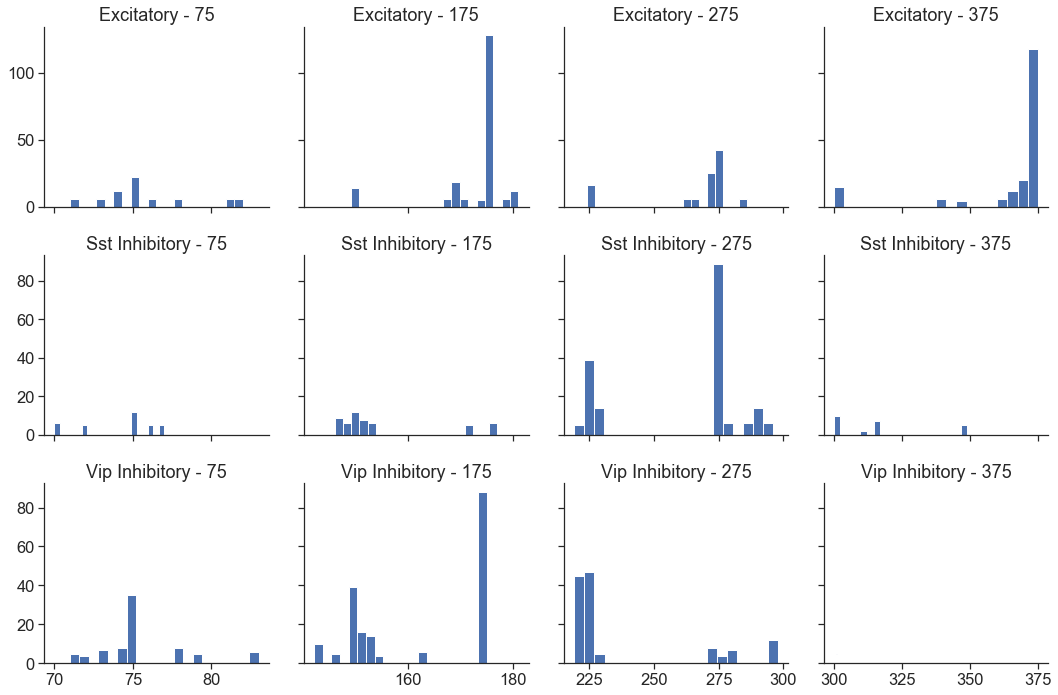

In [64]:
fig, ax = plt.subplots(3,4, figsize=(15,10), sharex='col', sharey='row')
ax = ax.ravel()
i = 0
for cell_type in np.sort(experiments_table.cell_type.unique()):
    for binned_depth in np.sort(experiments_table.binned_depth.unique()):
        data = experiments_table[(experiments_table.cell_type==cell_type)&(experiments_table.binned_depth==binned_depth)]
        ax[i].hist(data.depth.values, bins=20)
        ax[i].set_title(cell_type+' - '+str(binned_depth))
        i+=1
fig.tight_layout()

### The `area_depth` and `area_binned_depth` columns are useful to partition data by area and depth simultaneously

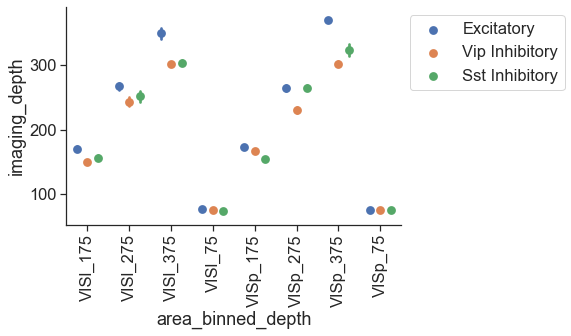

In [71]:
fig, ax = plt.subplots()
area_binned_depth = np.sort(experiments_table.area_binned_depth.unique())
sns.pointplot(data=experiments_table, x='area_binned_depth', y='imaging_depth', hue='cell_type', 
             order=area_binned_depth, join=False, dodge=0.5)
ax.set_xticklabels(area_binned_depth, rotation=90);
ax.legend(bbox_to_anchor=(1,1))